In [1]:
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/Hierarchical-BERT-Model-with-Limited-Labelled-Data/'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Let's test the setup by simply checking if all paths are present
present = True
necessary_paths= ['exercise_code']
files = os.listdir()
for path in necessary_paths:
    if path not in files:
        present = False
if not present:
    print("Can't find all required folders. You either installed the notebook in the wrong path or didn't upload the full exercise folder. You can check your paths in the file overview on the left.")
else:
    print('Google colab setup complete! Mounted folders:')
    print(files)

Mounted at /content/gdrive
Can't find all required folders. You either installed the notebook in the wrong path or didn't upload the full exercise folder. You can check your paths in the file overview on the left.


In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
np.random.seed(2019)

import html
import random
random.seed(2019)

from IPython.core.display import display, HTML
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.utils import shuffle

import os
os.environ['PYTHONHASHSEED'] = str(2019)

from nltk.corpus import words
import torch
torch.manual_seed(2019)
torch.cuda.manual_seed_all(2019)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


# OPTIONAL: if you want to have more information on what's happening under the hood, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

from operator import add

import re
import string

from nltk import sent_tokenize

# from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM
from numpy import genfromtxt
from tqdm import tqdm_notebook, trange
from transformers import *
from sklearn.model_selection import train_test_split
import operator



tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attentio

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



## Basic functions

In [ ]:
def read_data(path):

    corpora = []
    for filename in os.listdir(path):

        df_temp = pd.read_csv(path+filename, encoding='iso-8859-1')

        corpora.append(df_temp.text.tolist())

    class_one_len = len(corpora[0])
    class_two_len = len(corpora[1])

    return corpora, class_one_len, class_two_len


## split a document into sentences
def sentences_segmentation(corpora,tokenizer,min_token=0):
    segmented_documents = []
    iterator = tqdm_notebook(corpora, desc="Iteration")
    for idx,document in enumerate(iterator):
    # for i in tqdm(range(len(corpora))):

        segmented_document = []
        seg_document = sent_tokenize(document)

        ## remove sentences that are too short, the tokenized sentences should larger than min_token, otherwise are dropped
        for sentence in seg_document:
            tokenized_sentence = tokenizer.tokenize(sentence)
            if len(tokenized_sentence)>min_token:
                temp_sentence = tokenizer.convert_tokens_to_string(tokenized_sentence)
                ## if a whole sentence consists of punctations, it will be dropped
                if not all([j.isdigit() or j in string.punctuation for j in temp_sentence]):
                    segmented_document.append(temp_sentence)

        segmented_documents.append(segmented_document)

    return segmented_documents

# Prevent special characters like & and < to cause the browser to display something other than what you intended.
def html_escape(text):
    return html.escape(text)

## Import text data and split them into sentences

In [ ]:
import nltk
nltk.download('punkt')

paths = ['ecthr']


corpora, class_one_len, class_two_len = read_data('corpus_data/'+paths[0]+'/')

all_corpus = corpora[0]+corpora[1]

segmented_documents = sentences_segmentation(all_corpus,tokenizer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-4-13cd58b798cd>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  iterator = tqdm_notebook(corpora, desc="Iteration")


Iteration:   0%|          | 0/5002 [00:00<?, ?it/s]

In [ ]:
print('num of document in class one: ',class_one_len)
print('num of document in class two: ',class_two_len)

## lenghts of documents
lengths = []
for doc in segmented_documents:
    lengths.append(len(doc))

print('The length of longest document', np.max(lengths))
print('Avg length of document', np.mean(lengths))

num of document in class one:  2501
num of document in class two:  2501
The length of longest document 2144
Avg length of document 101.2233106757297


## Visualise the document lengths distributions

Text(0, 0.5, 'num of documents')

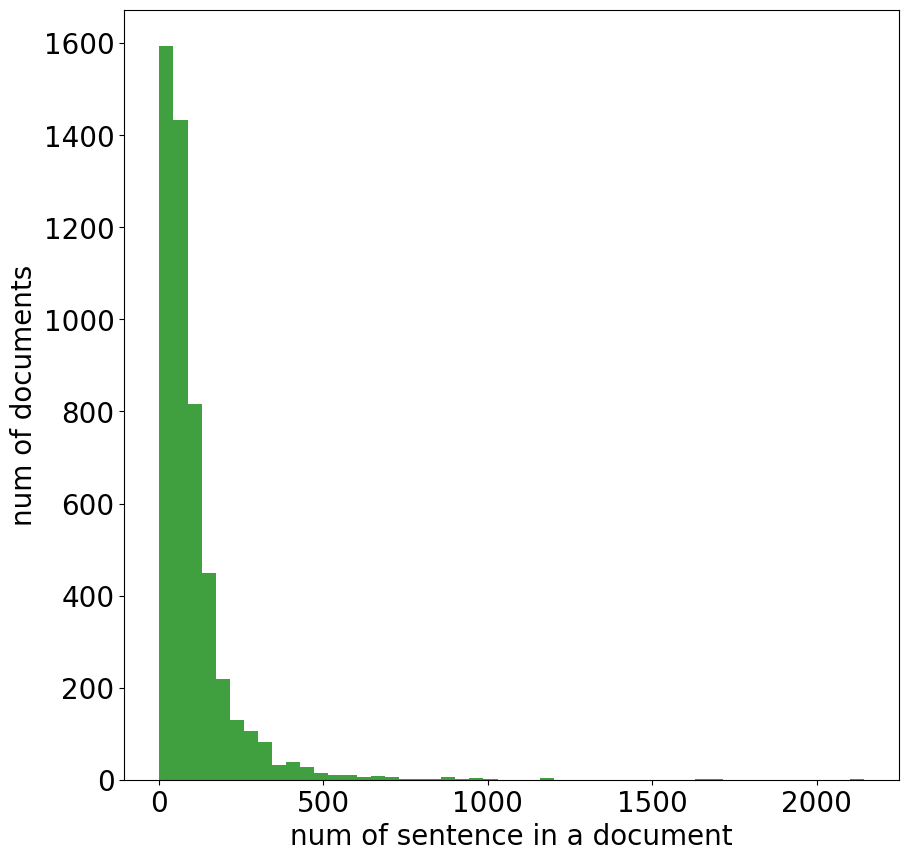

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(10,10))
n, bins,patchs = plt.hist(lengths, 50, facecolor='g', alpha=0.75)
plt.xlabel('num of sentence in a document')
plt.ylabel('num of documents')

## Print one splited document

In [ ]:
segmented_documents[0]

["On 28 September 1994 the applicant's husband, Salih Sabuktekin, a building contractor, was killed outside his house as he was getting into his van.",
 "He was a member of the pro-Kurdish political party, HADEP (the People's Democracy Party) and a delegate of the local YÃ¼regir/Adana branch.",
 'According to the witnesses, he was gunned down by two men in civilian clothes in front of a number of people, including his brother, Halil Sabuktekin, who was waiting for him in the vehicle.',
 "There are discrepancies between the parties' accounts of what took place, as regards both the timing of the incident and events immediately after the shooting.",
 'According to the applicant, the shooting took place between 6.30 a.m. and 7 a.m.',
 "Her brother-in-law, Halil Sabuktekin, attempted to chase his brother's killers but had been prevented from doing so by plainclothes police officers, who had proceeded to arrest him and taken him into police custody.",
 'In her observations of 31 March 1997 t

## Visualise informative sentences

In [ ]:
seed = 1999
epoch = 2
training_size = 3000
doc_idx=1
## hyperparameters of HBM: the maximum lenghth of document HBM can take
max_len = 108
cut_off = 0.5

attention_scores = torch.load('./attentions/%s/epoch%s_seed%s_size%s.pt'%(paths[0],epoch,seed,training_size))
print('./attentions/%s/epoch%s_seed%s_size%s.pt'%(paths[0],epoch,seed,training_size))
LABEL_emb = np.array([0]*class_one_len+[1]*class_two_len)

./attentions/ecthr/epoch2_seed1999_size3000.pt


In [ ]:
attention_scores.shape

torch.Size([2002, 1, 108, 108])

In [ ]:
## using the same randomisation as in the training HBM
index_shuffle = shuffle([i for i in range(len(all_corpus))], random_state=seed)

## get index of the testing documents
test_shuffle = index_shuffle[1600:]

test_segmented_documents = list(np.array(segmented_documents)[test_shuffle])
test_label = LABEL_emb[test_shuffle]
text_len = min(max_len,len(test_segmented_documents[doc_idx]))

<ipython-input-20-c18160595107>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_segmented_documents = list(np.array(segmented_documents)[test_shuffle])


In [ ]:
doc_attention_score = torch.tensor(attention_scores[doc_idx])

accum_attention_score = doc_attention_score[0].sum(axis=0)

<ipython-input-21-a9dabbc1c1a4>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  doc_attention_score = torch.tensor(attention_scores[doc_idx])


In [ ]:
weights = {}
max_weight = max(accum_attention_score)
for idx,attention in enumerate(accum_attention_score[:text_len]):
    weights[idx]=float(attention)

In [ ]:
max_alpha = max(weights.values())
highlighted_text = []
# length = min(len(weights),len(segmented_documents[doc_idx]))

for idx in range(text_len):
    weight = weights[idx]
    text = test_segmented_documents[doc_idx][idx]
    if weight/max_weight>cut_off:
        highlighted_text.append('<span style="background-color:rgba(135,206,290,' + str(weight/max_alpha) + ');">' + html_escape(text) + '</span>')
    else:
        highlighted_text.append(text)
highlighted_text = ' '.join(highlighted_text)
#highlighted_text

In [ ]:
print(test_label[doc_idx])
display(HTML(highlighted_text))
hello = open("/content/gdrive/MyDrive/Hierarchical-BERT-Model-with-Limited-Labelled-Data/attention.html", "a+")
hello.write(highlighted_text)
hello.close()


0


In [7]:
import pandas as pd
import json
import csv



# data = [json.loads(line) for line in open('res.json',"r")]
# with open("res.json", 'r') as file:
#     content = file.read()

# # Perform the replacement
# modified_content = content.replace("'", "\"")

# # Write the modified content back to the file
# with open("res_!.json", 'w+') as file:
#     file.write(modified_content)


import json

file_path = 'res.json'  # Replace 'data.txt' with the actual file path

# Step 1: Read the data from the file
with open(file_path, 'r') as file:
    data_str = file.read()

# Step 2: Parse the data string into a dictionary
data_dict = json.loads(data_str)

# Step 3: Extract values into lists
precision_list = []
recall_list = []
f1_score_list = []
support_list = []

for key, value in data_dict.items():
    if key.isnumeric():  # Only consider keys with numeric values
        precision_list.append(value['precision'])
        recall_list.append(value['recall'])
        f1_score_list.append(value['f1-score'])
        support_list.append(value['support'])

accuracy = data_dict['accuracy']
macro_avg_precision = data_dict['macro avg']['precision']
macro_avg_recall = data_dict['macro avg']['recall']
macro_avg_f1_score = data_dict['macro avg']['f1-score']
macro_avg_support = data_dict['macro avg']['support']

weighted_avg_precision = data_dict['weighted avg']['precision']
weighted_avg_recall = data_dict['weighted avg']['recall']
weighted_avg_f1_score = data_dict['weighted avg']['f1-score']
weighted_avg_support = data_dict['weighted avg']['support']

# Print the parsed values
print(f"Precision List: {precision_list}")
print(f"Recall List: {recall_list}")
print(f"F1-Score List: {f1_score_list}")
print(f"Support List: {support_list}")

print(f"Accuracy: {accuracy}")
print(f"Macro Avg Precision: {macro_avg_precision}")
print(f"Macro Avg Recall: {macro_avg_recall}")
print(f"Macro Avg F1-Score: {macro_avg_f1_score}")
print(f"Macro Avg Support: {macro_avg_support}")

print(f"Weighted Avg Precision: {weighted_avg_precision}")
print(f"Weighted Avg Recall: {weighted_avg_recall}")
print(f"Weighted Avg F1-Score: {weighted_avg_f1_score}")
print(f"Weighted Avg Support: {weighted_avg_support}")


JSONDecodeError: ignored